In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torchvision.transforms import Compose, ConvertImageDtype, Normalize, Resize

In [ ]:
DEFINITION = 128
NUMBER_OF_CHANNELS = 3

dtype = torch.bfloat16

test_transforms = Compose(
    transforms=[
        ConvertImageDtype(torch.float32),
        Resize(size=DEFINITION),
        Normalize(mean=[0.5] * NUMBER_OF_CHANNELS, std=[0.5] * NUMBER_OF_CHANNELS),
    ]
)

metrics_compute_transforms = Compose(
    [
        # 1: process images for inference (== training processing \ augmentations)
        test_transforms,  # test transforms *must* include the normalization to [-1, 1]
        # 2: if the model is inferring in f16, bf16, ..., then also discretize the true samples!
        ConvertImageDtype(dtype),
        # 3: convert to [0; 255] uint8 for PIL png saving
        Normalize(mean=[-1] * NUMBER_OF_CHANNELS, std=[2] * NUMBER_OF_CHANNELS),  # Convert from [-1, 1] to [0, 1]
        ConvertImageDtype(torch.uint8),  # this also scales to [0, 255]
    ]
)

# Base img

In [37]:
img = "/projects/static2dynamic/datasets/biotine/3_channels_min_99_perc_normalized_rgb_stacks_png/patches_255/1/A_13_fld_1_time_1_patch_0_1785.png"

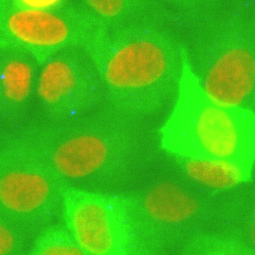

In [38]:
Image.open(img)

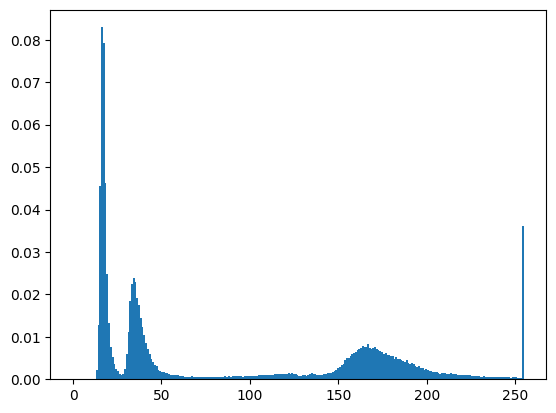

In [39]:
plt.hist(np.array(Image.open(img)).flatten(), bins=256, range=(0, 255), density=True)
plt.show()

# Into pt

In [40]:
img_pt = torch.from_numpy(np.array(Image.open(img))).permute(2, 0, 1)
img_pt.shape, img_pt.dtype, img_pt.min(), img_pt.max()

(torch.Size([3, 255, 255]),
 torch.uint8,
 tensor(11, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

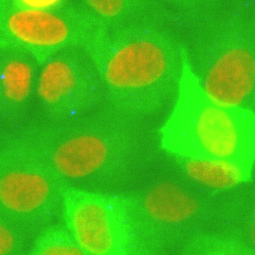

In [41]:
Image.fromarray(img_pt.permute(1, 2, 0).numpy())

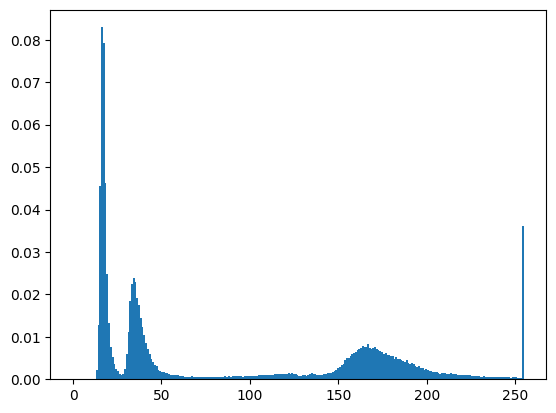

In [42]:
plt.hist(img_pt.flatten(), bins=256, range=(0, 255), density=True)
plt.show()

# Test trans

In [43]:
trans_pt = test_transforms(img_pt)
trans_pt.shape, trans_pt.dtype, trans_pt.min(), trans_pt.max()

(torch.Size([3, 128, 128]), torch.float32, tensor(-0.8878), tensor(1.0000))

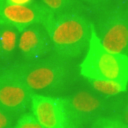

In [44]:
Image.fromarray(((trans_pt.permute(1, 2, 0).numpy() + 1) / 2 * 255).astype("uint8"))

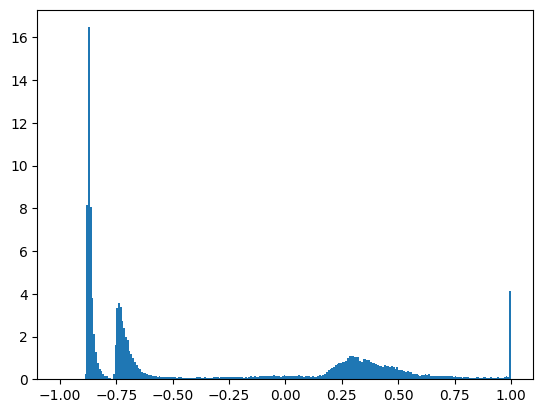

In [45]:
plt.hist(trans_pt.flatten(), bins=256, range=(-1, 1), density=True)
plt.show()

# to bf16

In [46]:
conv_pt = ConvertImageDtype(dtype)(trans_pt)
conv_pt.shape, conv_pt.dtype, conv_pt.min(), conv_pt.max()

(torch.Size([3, 128, 128]),
 torch.bfloat16,
 tensor(-0.8867, dtype=torch.bfloat16),
 tensor(1., dtype=torch.bfloat16))

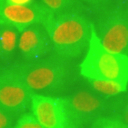

In [47]:
Image.fromarray(((conv_pt.permute(1, 2, 0).to(torch.float32).numpy() + 1) / 2 * 255).astype("uint8"))

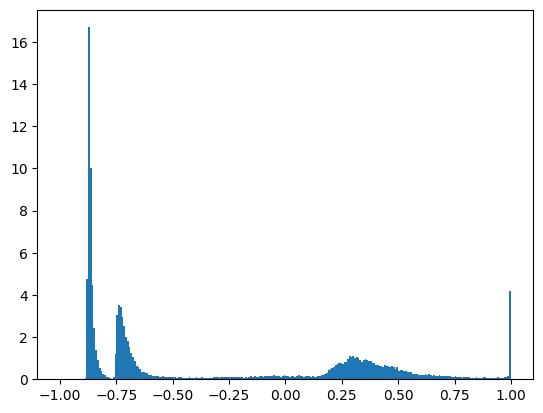

In [48]:
plt.hist(conv_pt.flatten().to(torch.float32), bins=256, range=(-1, 1), density=True)
plt.show()

# back to 0 1

In [ ]:
renomr_pt = Normalize(mean=[-1] * NUMBER_OF_CHANNELS, std=[2] * NUMBER_OF_CHANNELS)(conv_pt)
renomr_pt.shape, renomr_pt.dtype, renomr_pt.min(), renomr_pt.max()

(torch.Size([3, 128, 128]),
 torch.bfloat16,
 tensor(0.0566, dtype=torch.bfloat16),
 tensor(1., dtype=torch.bfloat16))

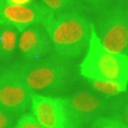

In [ ]:
Image.fromarray((renomr_pt.permute(1, 2, 0).to(torch.float32).numpy() * 255).astype("uint8"))

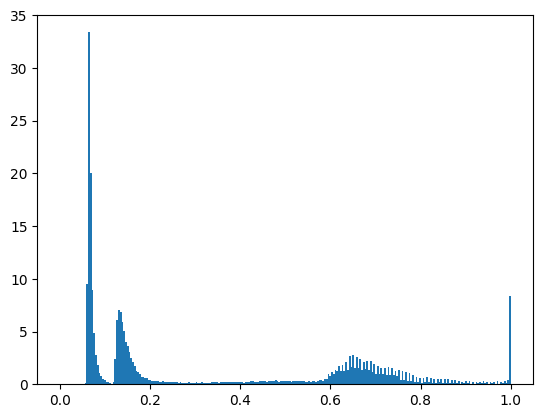

In [51]:
plt.hist(renomr_pt.flatten().to(torch.float32), bins=256, range=(0, 1), density=True)
plt.show()

other test: manual scale to 0 1

torch.Size([3, 128, 128]) torch.bfloat16 tensor(-0.8867, dtype=torch.bfloat16) tensor(1., dtype=torch.bfloat16)
torch.Size([3, 128, 128]) torch.bfloat16 tensor(0.1133, dtype=torch.bfloat16) tensor(2., dtype=torch.bfloat16)
torch.Size([3, 128, 128]) torch.bfloat16 tensor(0.0566, dtype=torch.bfloat16) tensor(1., dtype=torch.bfloat16)


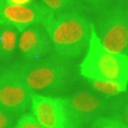

In [ ]:
renomr_pt_manual = conv_pt.clone()
print(
    renomr_pt_manual.shape,
    renomr_pt_manual.dtype,
    renomr_pt_manual.min(),
    renomr_pt_manual.max(),
)
renomr_pt_manual += 1
print(
    renomr_pt_manual.shape,
    renomr_pt_manual.dtype,
    renomr_pt_manual.min(),
    renomr_pt_manual.max(),
)
renomr_pt_manual /= 2
print(
    renomr_pt_manual.shape,
    renomr_pt_manual.dtype,
    renomr_pt_manual.min(),
    renomr_pt_manual.max(),
)

Image.fromarray((renomr_pt_manual.permute(1, 2, 0).to(torch.float32).numpy() * 255).astype("uint8"))

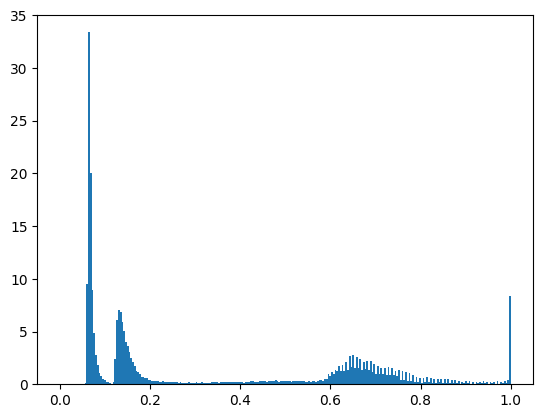

In [ ]:
plt.hist(renomr_pt_manual.flatten().to(torch.float32), bins=256, range=(0, 1), density=True)
plt.show()

# to uint8

In [54]:
scaled_pt = ConvertImageDtype(torch.uint8)(renomr_pt)
scaled_pt.shape, scaled_pt.dtype, scaled_pt.min(), scaled_pt.max()

(torch.Size([3, 128, 128]),
 torch.uint8,
 tensor(0, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

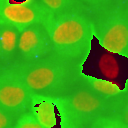

In [55]:
Image.fromarray(scaled_pt.permute(1, 2, 0).numpy())

reference:

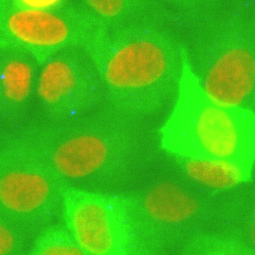

In [56]:
Image.open(img)

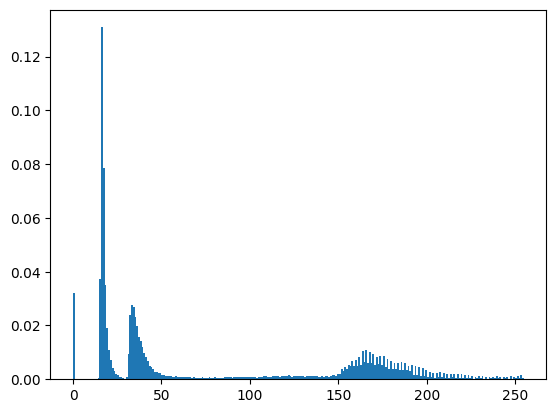

In [57]:
plt.hist(scaled_pt.flatten(), bins=256, range=(0, 255), density=True)
plt.show()

reference:

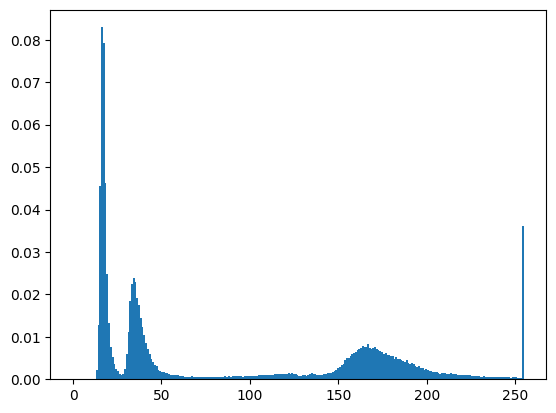

In [58]:
plt.hist(np.array(Image.open(img)).flatten(), bins=256, range=(0, 255), density=True)
plt.show()

# to uint8 but f32 just before

In [65]:
renomr_pt.shape, renomr_pt.dtype, renomr_pt.min(), renomr_pt.max()

(torch.Size([3, 128, 128]),
 torch.bfloat16,
 tensor(0.0566, dtype=torch.bfloat16),
 tensor(1., dtype=torch.bfloat16))

In [64]:
tmp = ConvertImageDtype(torch.float32)(renomr_pt)
tmp.shape, tmp.dtype, tmp.min(), tmp.max()

(torch.Size([3, 128, 128]), torch.float32, tensor(0.0566), tensor(1.))

In [ ]:
# scaled_pt_f32_just_before = ConvertImageDtype(torch.uint8)(renomr_pt.to(torch.float32))
scaled_pt_f32_just_before = ConvertImageDtype(torch.uint8)(ConvertImageDtype(torch.float32)(renomr_pt))
(
    scaled_pt_f32_just_before.shape,
    scaled_pt_f32_just_before.dtype,
    scaled_pt_f32_just_before.min(),
    scaled_pt_f32_just_before.max(),
)

(torch.Size([3, 128, 128]),
 torch.uint8,
 tensor(14, dtype=torch.uint8),
 tensor(255, dtype=torch.uint8))

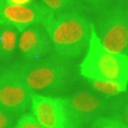

In [60]:
Image.fromarray(scaled_pt_f32_just_before.permute(1, 2, 0).numpy())

reference:

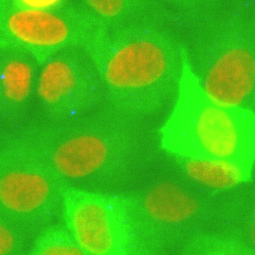

In [61]:
Image.open(img)

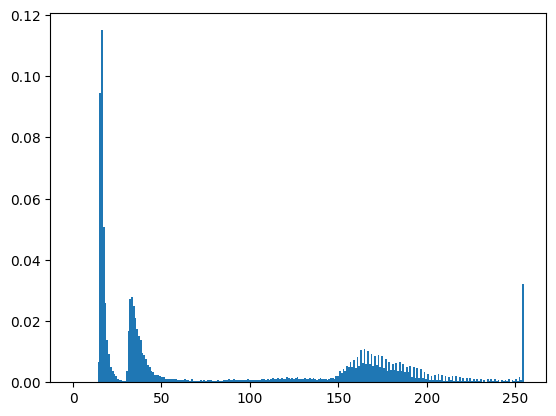

In [62]:
plt.hist(scaled_pt_f32_just_before.flatten(), bins=256, range=(0, 255), density=True)
plt.show()

reference:

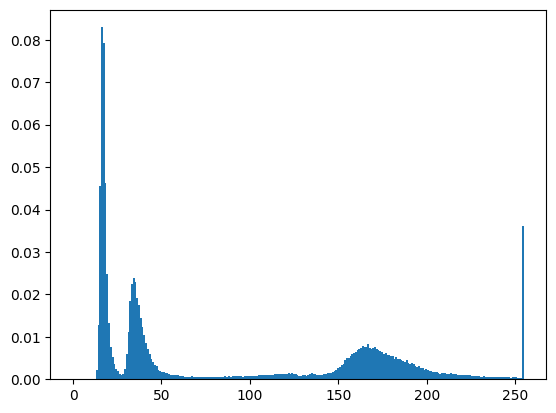

In [63]:
plt.hist(np.array(Image.open(img)).flatten(), bins=256, range=(0, 255), density=True)
plt.show()